<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 2
</div>

<hr>

### Overview

The objective of image segmentation is to partition an image into parts. We can roughly distinguish between edge-based and region-based segmentation. This task sheet addresses edge-based segmentation in the form of edge detection, where region boundaries are detected based on local intensity (gray level) discontinuities using first- and second order derivatives.

In comparison to first order derivatives, second order derivatives can be implemented in an isotropic manner with a single filter mask. First order derivatives are nonzero *everywhere* along a graylevel ramp and can therefore lead to thick edges, while second order derivatives are only nonzero at the beginning and end of a graylevel ramp. Here and at step transitions, second order derivatives have double responses in the form of zero-crossings. These zero-crossings can be used for edge detection. This is what we study in Task 2.1. On the other hand, second order derivatives are more sensitive to noise.

The Canny Edge Detector (Task 2.2) uses four edge types based on the gradient $|\nabla f|$: vertical, horizontal, and +/-45 deg edges. These types are used for nonmaxima suppression. The following figure visualizes the principle, the colors can be used to indicate the corresponding gradient directions $\alpha$ in a plot (e.g., vertical edge means <span style="color:red;">horizontal</span> gradient):

<br />
<center><img src="images/gradient-directions.png"  width="800px" /></center>
<br />

The main steps for edge detection are usually as follows:
1. Image smoothing for noise reduction and maintaining connectivity.
2. Detection of edge point candidates.
3. Edge localization based on candidate points.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 2.1</span> Marr-Hildreth Edge Detector

This method is one of the first successfull advanced edge detection algorithms. The authors, <a href="http://www.hms.harvard.edu/bss/neuro/bornlab/qmbc/beta/day4/marr-hildreth-edge-prsl1980.pdf">Marr and Hildreth (1980)</a>, argued that (1) intensity changes are not independent of image scale so that it should be possible to change the operator (mask) size; and (2) that sudden intensity changes lead to zero crossings in the second derivative.

The algorithm can be summarized in three steps:
1. Filter the image with an $n \times n$ Gaussian filter mask ($n =$ smallest odd integer not less than $6\sigma$).
2. Compute the Laplacian of this image, for example using a $3 \times 3$ kernel.
3. Find the zero-crossings of this image and apply thresholding.

The size of the Gaussian is chosen like this because values at distances larger than $3\sigma$ from the mean can usually be ignored. It is also possible to combine step 1 and 2 by using a LoG mask directly, but it is more easy to compute a Gaussian mask for a given $\sigma$ and computing the Laplacian, than computing the corresponding LoG mask with the additional property that the coefficients sum up to zero. The latter is required to have a zero response in areas of constant intensity. Comparing the values of the LoG image against a threshold can be used to extract strong edges only.

Implement / solve the following tasks:
1. Implement the Marr-Hildreth Edge Detector as described above.
2. Test the algorithm for different test images and change the parameters where required.

For the development, plot all intermediate results. The OpenCV function <a href="https://docs.opencv.org/4.2.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1">`GaussianBlur`</a> can be used for filtering with a Gaussian mask.

Grayscale image:


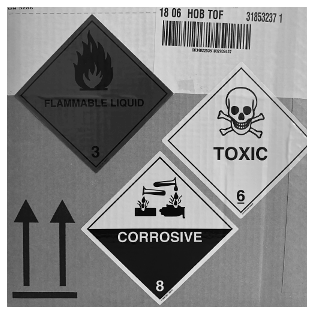

Gaussian filtered: sigma = 1.0, n = 7


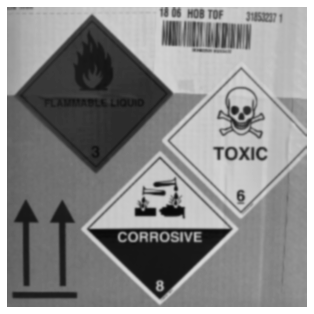

Laplacian (normalized):


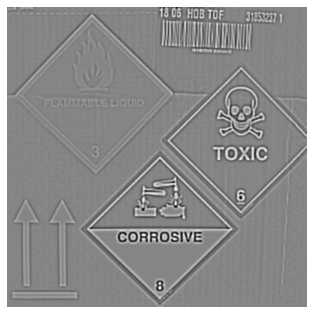

Laplacian (only positive values):


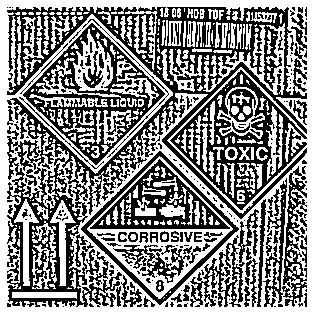

Edge image:


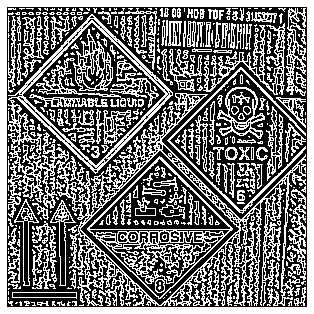

Edge image (thresholded):


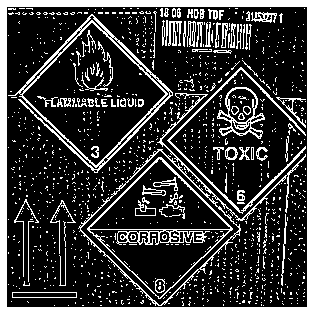

In [2]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/hazmats-small.png', 0)
rows, cols = img.shape
print("Grayscale image:")
plot_img_orig(img)

# parameters
sigma = 1.0
threshold = 5.0

# compute the required mask size
n = int(np.ceil(6*sigma)) # ceil rounds up
if (n % 2 == 0): n = n + 1 # closest odd integer
        
# step 1: compute Gaussian filtered image
img_gauss = cv2.GaussianBlur(img.astype(np.float64), (n, n), sigma)
print("Gaussian filtered: sigma = " + str(sigma) + ", n = " + str(n))
plot_img_orig(img_gauss)

# step 2: compute Laplacian of this image
laplace = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
img_log = cv2.filter2D(img_gauss, cv2.CV_64FC1, laplace)
print("Laplacian (normalized):")
plot_img_orig(cv2.normalize(img_log, None, 0, 255, cv2.NORM_MINMAX))

# plot positive values (only for analysis / visualization)
img_log_p = (img_log > 0) * 255 # (img_log > 0) returns array with ones where true
print("Laplacian (only positive values):")
plot_img_orig(img_log_p)

# step 3: find zero-crossings (ignore image border)
# find edges (positive pixels that have a direct negative neighbor)
edges = np.zeros(shape=[rows, cols], dtype=np.uint8) # init with zeros
for i in range(1, rows-1):
    for j in range(1, cols-1):
        if img_log[i, j] > 0:
            if img_log[i-1, j-1] < 0 or \
               img_log[i-1, j] < 0 or \
               img_log[i-1, j+1] < 0 or \
               img_log[i, j+1] < 0 or \
               img_log[i+1, j+1] < 0 or \
               img_log[i+1, j] < 0 or \
               img_log[i+1, j-1] < 0 or \
               img_log[i, j-1] < 0:
                
                # negative neighbor found
                edges[i, j] = 255
            else:
                edges[i, j] = 0
                
# plot final result
print("Edge image:")
plot_img_orig(edges)

# thresholded edge image
edges_t = (img_log > threshold) * edges # (img_log > 0.8) returns array with ones where true
print("Edge image (thresholded):")
plot_img_orig(edges_t)

Different methods can be used to detect the zero crossings. In this example, we simply search for positive values in the LoG image and check if they have negative neighbors. If this is the case, a zero-crossing has been found. Note that the positive values in the LoG image form connected regions. If we then search for zero-crossings in the way just described, they are (usually) the borders of these regions. This leads to closed contours, which is characteristic for this method and known as the spaghetti effect. The effect can be a drawback in some applications.

#### <span style="color: RoyalBlue; font-weight: bold;">Task 2.2</span> Canny Edge Detector

The Canny Edge Detector, named after his author <a href="https://ieeexplore.ieee.org/abstract/document/4767851">Canny (1986)</a>, is one of the most famous edge detection algorithms and is still widely used today. The algorithm is based on three objectives: low error rate, well-localized edge points, and single edge point responses (ideally leading to 1 px wide edges). Based on a mathematical formalization of these principles, the algorithm can be summarized as follows:
1. Smooth the input image with a Gaussian filter.
2. Compute the gradient magnitude and angle images.
3. Apply nonmaxima suppression to the gradient magnitude image.
4. Use double (hysteresis) thresholding to identify non-relevant, weak, and strong edges.
5. Use connectivity analysis to link weak and strong edges.

The first step is used to supress noise and the gradient is used to detect edges. The gradient is often implemented using Sobel masks. The gradient image $|\nabla f|$ typically contains wide ridges around local maxima (see overview for reasons). To thin these ridges, nonmaxima suppression can be used. This works as follows: If $|\nabla f|$ is smaller then at least one of its two neighbours along the gradient direction (only four directions are possible, see overview), then supress it (set it zero), otherwise let it pass. By this means, only one (or very few) large value(s) are kept.

Single thresholding has the following problem: if the threshold is too low, many non-relevant edge pixels are detected (false positives). If it is too high, many strong edge pixels are discarded. Double (hysteresis) thresholding addresses this as follows: using a low threshold $T_L$ and a high threshold $T_H$, all pixels lower then $T_L$ are non-relevant, all pixels higher than $T_H$ are strong edges and definitely kept, and the pixels inbetween are weak and integrated (kept) if they are connected to strong edges (strong edges are therefore completed). It can be shown that $T_H/T_L$ should be in the range of $2/1$ to $3/1$. This idea of adding weak pixels to strong edges in a later step explains the naming: hysteresis = lagging behind. In summary, a weak pixel is kept if it is 8-connected to a strong pixel.

Implement / solve the following tasks:
1. Implement the Canny Edge Detector as described above.
2. Test the algorithm for different test images and change the parameters where required.

For the development, plot all intermediate results, especially the color coded gradient directions. The OpenCV function <a href="https://docs.opencv.org/master/da/d22/tutorial_py_canny.html">`Canny`</a> (not to be used here) combines all steps.

Input image:


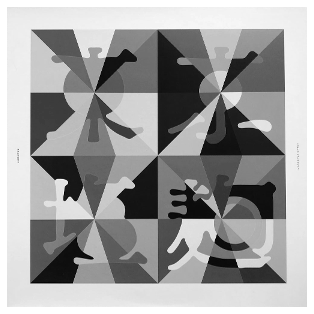

Gaussian filtered:


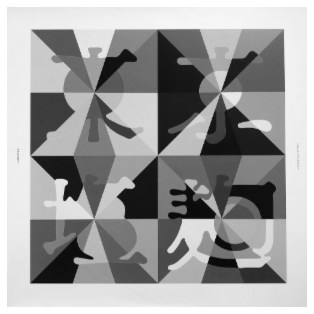

Magnitude (normalized):


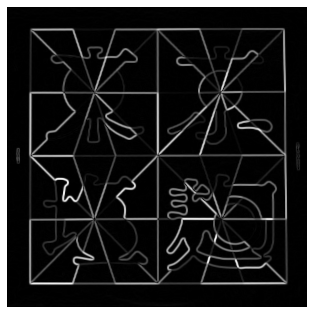

Gradient directions:


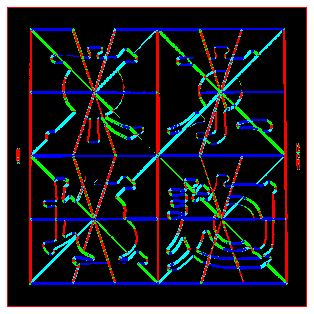

Nonmaxima suppression:


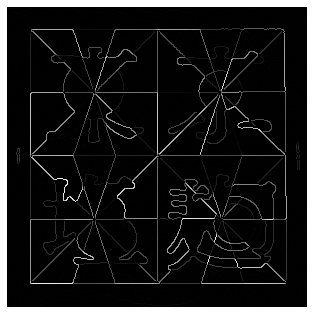

High threshold:


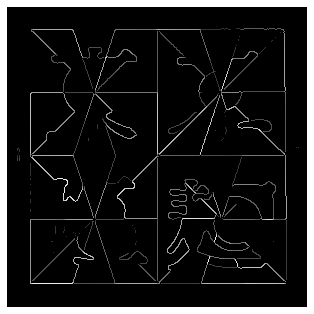

Low threshold:


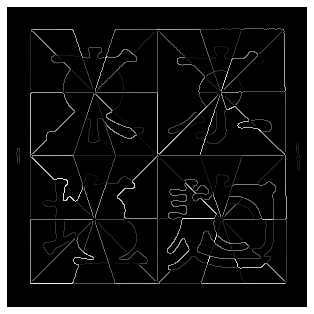

Weak pixels (Low without high):


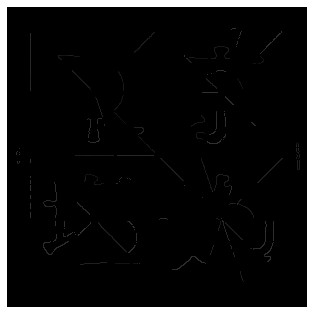

Edges without weak pixels:


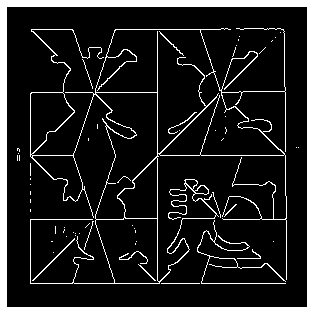

Edges with 8-connected weak pixels:


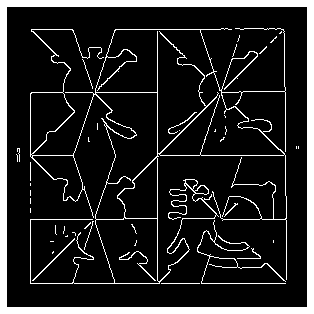

In [3]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/vinyl-small.png', 0)
rows, cols = img.shape
print("Input image:")
plot_img_orig(img)

# step 1: smooth the input image
img_gauss = cv2.GaussianBlur(img.astype(np.float64), (3, 3), 0.5)
print("Gaussian filtered:")
plot_img_orig(img_gauss)

# step 2: compute the gradient magnitude and angle images
sobel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]); #print(sobel_x)
sobel_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]); #print(sobel_y)

# compute g_x and g_y (derivatives in x and y direction)
g_x = cv2.filter2D(img_gauss, cv2.CV_64F, sobel_x)
g_y = cv2.filter2D(img_gauss, cv2.CV_64F, sobel_y)

# magnitude
magnitude = np.sqrt(np.square(g_x) + np.square(g_y)) #.astype(np.uint8) the accuracy influences the nms
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
print("Magnitude (normalized):")
plot_img_orig(magnitude)

# gradient angle (gradient direction)
angle = np.arctan2(g_y, g_x) * 180 / np.pi # includes rad to deg

# step 3: nonmaxima suppression (nms)
nms = np.zeros(shape=[rows, cols], dtype=np.uint8)

# gradient direction: four possible types (labeled with colors for visualization)
directions = np.zeros(shape=[rows, cols, 3], dtype=np.uint8) # init with zeros
directions[:,:,1] = 255 # hue
directions[:,:,2] = 255 # saturation

for i in range(1, rows-1):
    for j in range(1, cols-1):
        # get current angle
        a = angle[i, j]
        
        # neighbors along gradient direction
        n1 = 0 # neighbor 1
        n2 = 0 # neighbor 2
        
        # horizontal edge (vertical gradient)
        if (a > -22.5 and a < 22.5) or (a < -157.5) or (a > 157.5):
            n1 = magnitude[i-1, j]
            n2 = magnitude[i+1, j]

            directions[i, j, 0] = 120 # blue
        
        # -45 deg diagonal edge
        elif (a > -157.5 and a < -112.5) or (a < 67.5 and a > 22.5):
            n1 = magnitude[i-1, j-1]
            n2 = magnitude[i+1, j+1]
            
            directions[i, j, 0] = 90 # cyan
            
        # vertical edge (horizontal gradient)
        elif (a >= -112.5 and a <= -67.5) or (a <= 112.5 and a >= 67.5):
            n1 = magnitude[i, j-1]
            n2 = magnitude[i, j+1]
            
            directions[i, j, 0] = 0 # red
            
        # 45 deg diagonal edge
        else:
            n1 = magnitude[i-1, j+1]
            n2 = magnitude[i+1, j-1]
            
            directions[i, j, 0] = 60 # green
         
        # visualization: exclude low magnitude pixels
        if magnitude[i, j] < 20.0:
            directions[i, j, 2] = 0 # value
            
        # apply nonmaxima suppression
        if not ((magnitude[i, j] < n1) or (magnitude[i, j] < n2)):
            nms[i, j] = magnitude[i, j]
                 
# plot color coded gradient directions
directions_rgb = cv2.cvtColor(directions, cv2.COLOR_HSV2RGB)
print("Gradient directions:")
plot_img_orig(directions_rgb)

# result of nonmaxima suppression
print("Nonmaxima suppression:")
plot_img_orig(nms)

# step 4: double (hysteresis) thresholding
t_h = 50 # high threshold
t_l = t_h / 3 # low threshold

nms_h = (nms >= t_h) * nms # (nms >= t_h) returns array with ones where true
nms_l = (nms >= t_l) * nms

print("High threshold:")
plot_img_orig(nms_h)

print("Low threshold:")
plot_img_orig(nms_l)

# remove nms_h pixels from nms_l 
nms_l = nms_l - nms_h
print("Weak pixels (Low without high):")
plot_img_orig(nms_l)

# edge image
edges = (nms_h > 0) * 255
print("Edges without weak pixels:")
plot_img_orig(edges)

# step 5: connectivity analysis
for i in range(1, rows-1):
    for j in range(1, cols-1):
        if nms_l[i, j] > 0: # check clockwise from top left
            if nms_h[i-1, j-1] > 0 or \
               nms_h[i-1, j] > 0 or \
               nms_h[i-1, j+1] > 0 or \
               nms_h[i, j+1] > 0 or \
               nms_h[i+1, j+1] > 0 or \
               nms_h[i+1, j] > 0 or \
               nms_h[i+1, j-1] > 0 or \
               nms_h[i, j-1] > 0:
                
                # weak pixel is valid edge pixel
                edges[i, j] = 255
                
# final result
print("Edges with 8-connected weak pixels:")
plot_img_orig(edges)

Note that the color encoding for the angles can refer to the edge angle instead of to the gradient angle in other references. Furthermore, we have created new images in nearly each sub-step. This is helpful for development purposes, but a more compact implemenation with less variables is possible. Depending on the implementation of the nonmaxima supression, the detected edges can still be wider than one pixel. If these are not acceptable, an additional edge-thinning algorithm can be used after this step or after the complete algorithm.